# ⚯ Pair Programming - Dimensionality Reduction

## Introduction

In this cumulative lab, you'll apply dimensionality reduction as a preprocessing step in a machine learning workflow.

## Objectives

You will be able to: 

- Practice performing PCA using the scikit-learn library
- Interpret the amount of variance captured by a given number of PCA components
- Evaluate model performance with and without dimensionality reduction
- Plot the decision boundary of classification experiments to visually inspect their performance 

## Your Task: Reduce the Dimensionality of the Iris Dataset as Part of a Machine Learning Workflow

![irises](images/iris.jpg)

<span>Photo by <a href="https://unsplash.com/@yoksel?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Yoksel 🌿 Zok</a> on <a href="https://unsplash.com/s/photos/iris?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

### Dimensionality Reduction in ML

While it is possible to use dimensionality reduction as a standalone analysis technique, you will frequently see it used as a preprocessing step in a predictive machine learning workflow.

The two main reasons to use dimensionality reduction in machine learning are:

1. **Reducing computational complexity:** Often the internal logic of a machine learning algorithm means that the complexity increases by an order of magnitude with every additional dimension (feature). So maybe there are {n^2} operations for 2 features, {n^4} operations for 4 features, etc. If we can reduce the number of dimensions (features) prior to fitting/predicting with the model, the model will be faster and use fewer computational resources (memory, processing power, etc.)
2. **Improving model performance:** In some cases even if we had unlimited computational capacity, our models would still struggle to fit on data with too many dimensions, known as the *curse of dimensionality*. Generally this applies when there are hundreds of features (or more). We can also sometimes see reductions in overfitting with dimensionality reduction, depending on the data and the model.

There is no guarantee that dimensionality reduction will produce improved results — it all depends on how your features are related to each other, and the details of the machine learning algorithm you are using. In this lab you will walk through several different dimensionality reduction techniques and observe their impacts on the modeling process.

### The Iris Dataset

For this lab you will use the Iris Dataset that comes with scikit-learn. This is a classic "toy" dataset where we are trying to identify the species of iris based on the provided attributes.

In [1]:
from sklearn import datasets
import pandas as pd
 
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.get('target')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Part of why we use this dataset for so many examples is that there is clear predictive power in each of the features (i.e. the distributions of feature values differ for each of the targets):

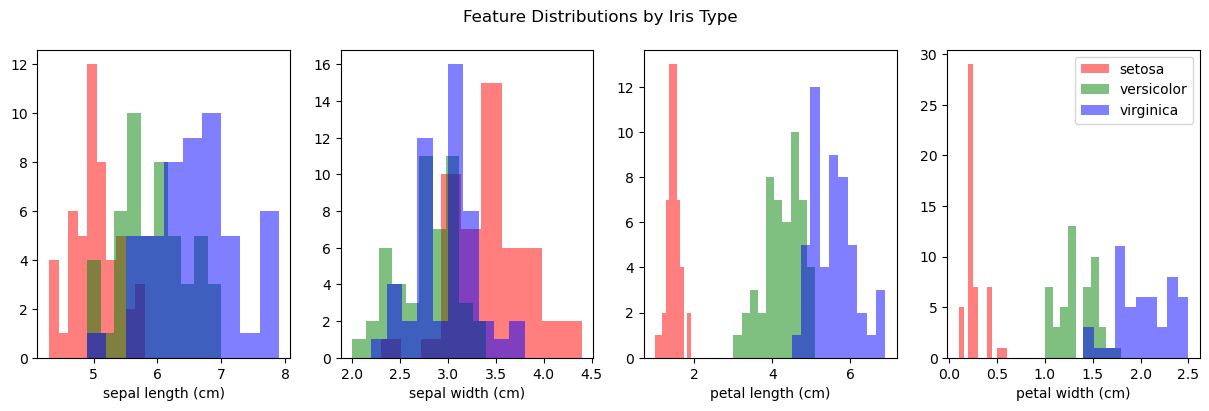

In [2]:
import matplotlib.pyplot as plt

# Set up figure and axes
fig, axes = plt.subplots(ncols=4, figsize=(15,4))

# Loop over each feature
for feature_index, feature_name in enumerate(iris.feature_names):
    
    # Find the relevant axes from the list and give it a label
    ax = axes[feature_index]
    ax.set_xlabel(feature_name)
    
    # Loop over the three target values and plot them by color
    colors = ['r', 'g', 'b']
    for target_index, target_name in enumerate(iris.target_names):
        subset_rows = df[df["target"] == target_index]
        ax.hist(
            subset_rows[feature_name],
            label=target_name,    
            color=colors[target_index],
            alpha=0.5
        )
        
# Add a legend to the last axes only
ax.legend()

# Set a title for the overall plot
fig.suptitle("Feature Distributions by Iris Type");

### Requirements

#### 1. Perform a Train-Test Split

Because we are using dimensionality reduction within a predictive modeling context, we need to perform a train-test split prior to taking any other steps.

#### 2. Scale Data

Both the model we are using (logistic regression with regularization) and our dimensionality reduction techniques are distance-based, so we need to scale our data before performing any analysis.

#### 3. Evaluate Model Performance without PCA

Before performing PCA, fit a vanilla logistic regression model on the provided features and evaluate its performance, including the time taken.

#### 4. Perform and Visualize PCA

Using the `PCA` transformer class from scikit-learn, fit and transform the training data so that the four dimensions of the original features have been projected down to two dimensions. Identify how much of the variance is captured, and plot the data points using these two dimensions as the x-axis and y-axis.

#### 5. Evaluate Model Performance with PCA

Fit and evaluate a new logistic regression model on the transformed data.

#### BONUS: Manifold Dimensionality Reduction

Another, more-advanced technique to consider for dimensionality reduction is *manifold learning*. Fortunately scikit-learn also provides an interface to this technique that works the same way as any other transformer.

## 1. Perform a Train-Test Split

Currently all of the data is contained in a dataframe called `df`, where the target (y value) is labeled `"target"`. In the cell below, separate the data into `X` and `y`, then use `train_test_split` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) with `random_state=42` to create training and test datasets.

In [3]:
# Import the relevant function
from sklearn.model_selection import train_test_split

# Separate X and y
X = df.drop(columns='target')
y = df['target']

# Perform train-test split with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)


Make sure your data has the appropriate shape before moving forward:

In [4]:
# Both train and test X should have 4 columns
assert (X_train.shape[1] == 4) and (X_test.shape[1] == 4)

# Both train and test y should have 1 column
assert (len(y_train.shape) == 1) and (len(y_test.shape) == 1)

# Train X and y should have the same number of rows
assert X_train.shape[0] == y_train.shape[0]

# Test X and y should have the same number of rows
assert X_test.shape[0] == y_test.shape[0]

## 2. Scale Data

Use the `StandardScaler` class from scikit-learn ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)) to preprocess the data. Make sure you fit the scaler on the training data only, and transform both the train and test data.

In [5]:
# Import the relevant function
from sklearn.preprocessing import StandardScaler

# Instantiate a scaler
scaler = StandardScaler()

# Fit the scaler on X_train
scaler.fit(X_train)

# Transform X_train and X_test. Go ahead and reuse the variable names
# "X_train" and "X_test" since we won't need the un-scaled data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Now the values should be scaled
pd.DataFrame(X_train, columns=iris.feature_names)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-1.473937,1.203658,-1.562535,-1.312603
1,-0.133071,2.992376,-1.276006,-1.045633
2,1.085898,0.085709,0.385858,0.289218
3,-1.230143,0.756479,-1.218701,-1.312603
4,-1.717731,0.309299,-1.390618,-1.312603
...,...,...,...,...
115,0.354517,-0.585060,0.156636,0.155733
116,-1.108246,-1.255829,0.443164,0.689673
117,-0.011174,2.098017,-1.447923,-1.312603
118,-0.011174,-1.032239,0.156636,0.022248


## 3. Evaluate Model Performance without PCA

In the cell below, instantiate a `LogisticRegression` model ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) with `random_state=42`.

In [6]:
# Import the relevant class
from sklearn.linear_model import LogisticRegression

# Instantiate the model with random_state=42
baseline_model = LogisticRegression(random_state=42)

# Display the instantiated model
baseline_model


LogisticRegression(random_state=42)

Now fit the model on the training data and score it on the test data (using the `.score` method).

In [7]:
# Import the relevant class
from sklearn.linear_model import LogisticRegression
import time

# Instantiate the model with random_state=42
baseline_model = LogisticRegression(random_state=42)

start = time.time()

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Score the model on the test data
baseline_model_score = baseline_model.score(X_test, y_test)

end = time.time()
baseline_time_taken = end - start

print("Model score:", baseline_model_score)
print("Time taken:", baseline_time_taken)


Model score: 1.0
Time taken: 0.03462052345275879


In [8]:
baseline_model_score

1.0

Ok, so it looks like we are getting essentially perfect performance with our baseline classifier, and it is taking aroud 8ms (timing will vary depending on your system).

Now let's investigate using PCA to reduce the dimensions of the data.

## 4. Perform and Visualize PCA

### Performing PCA

As demonstrated in a previous lesson, PCA can be applied relatively simply using the scikit-learn library. Just like with the `StandardScaler`, you'll need to instantiate a `PCA` transformer, fit it on the training data, and transform both the train and the test data. You can find documentation for the `PCA` class [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

We'll set `n_components` to `2`, meaning that we will only keep the first two principal components.

In [9]:
# Import the relevant class
from sklearn.decomposition import PCA

# Instantiate the PCA transformer with n_components=2
pca = PCA(n_components=2)

# Fit the transformer on X_train
pca.fit(X_train)

# Transform X_train and X_test. This time, create new
# variables for the transformed data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Display the transformed training data
pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])


,PC1,PC2
0,-2.741058,0.415798
1,-2.214577,2.604762
2,0.926828,0.529167
3,-2.293429,0.108078
4,-2.524548,-0.496938
...,...,...
115,0.521362,-0.385743
116,0.415127,-1.535405
117,-2.159999,1.811532
118,0.377947,-0.947346


Now, our PCA-transformed X values should have the same number of rows as before, but a different number of columns:

In [10]:
# Same number of rows, different number of columns
assert X_train_pca.shape[0] == X_train.shape[0]
assert X_train_pca.shape[1] != X_train.shape[1]

# Specifically, the transformed data should have 2 columns
# because we set n_components=2
assert X_train_pca.shape[1] == 2

pd.DataFrame(X_train_pca, columns=["PC 1", "PC 2"])

,PC 1,PC 2
0,-2.741058,0.415798
1,-2.214577,2.604762
2,0.926828,0.529167
3,-2.293429,0.108078
4,-2.524548,-0.496938
...,...,...
115,0.521362,-0.385743
116,0.415127,-1.535405
117,-2.159999,1.811532
118,0.377947,-0.947346


### Visualizing Principal Components 

Using the target data, we can visualize the principal components according to the class distribution. 

Create a scatter plot from principal components, where the color of the dot is based on the target value.

First, separate `X_train_pca` based on the associated target value in `y_train`. Create dataframes `setosa` (target = 0), `versicolor` (target = 1), and `virginica` (target = 2) using the dataframe created below.

In [12]:
import pandas as pd

# Initialize the DataFrame
train_combined_pca = pd.DataFrame(columns=["PC 1", "PC 2", "target"])

# Populate the DataFrame
train_combined_pca["PC 1"] = X_train_pca[:, 0]
train_combined_pca["PC 2"] = X_train_pca[:, 1]
train_combined_pca["target"] = y_train.values

# Display the DataFrame
train_combined_pca.head()


,PC 1,PC 2,target
0,-2.741058,0.415798,0
1,-2.214577,2.604762,0
2,0.926828,0.529167,1
3,-2.293429,0.108078,0
4,-2.524548,-0.496938,0


In [14]:
# Rows of train_combined_pca where target is 0
setosa = train_combined_pca[train_combined_pca["target"] == 0]

# Rows of train_combined_pca where target is 1
versicolor = train_combined_pca[train_combined_pca["target"] == 1]

# Rows of train_combined_pca where target is 2
virginica = train_combined_pca[train_combined_pca["target"] == 2]

# Display the DataFrames
print("Setosa:\n", setosa.head())
print("\nVersicolor:\n", versicolor.head())
print("\nVirginica:\n", virginica.head())


Setosa:
        PC 1      PC 2  target
0 -2.741058  0.415798       0
1 -2.214577  2.604762       0
3 -2.293429  0.108078       0
4 -2.524548 -0.496938       0
7 -2.135143  0.502812       0

Versicolor:
         PC 1      PC 2  target
2   0.926828  0.529167       1
6   0.785811  0.600686       1
11  0.487716  0.828563       1
12  1.102403  0.540927       1
15  0.058958 -1.520708       1

Virginica:
         PC 1      PC 2  target
5   1.615929 -0.845685       2
10  1.212657 -0.672244       2
16  1.165497 -0.260626       2
17  1.406543  0.431930       2
19  2.336444  1.903319       2


The code below checks that the dataframes have the correct length:

In [15]:

train_value_counts = y_train.value_counts()

assert len(setosa) == train_value_counts[0]
assert len(versicolor) == train_value_counts[1]
assert len(virginica) == train_value_counts[2]

Now we can set up the actual scatter plots.

Notes:

* You'll need to call `ax.scatter` three times, once with each of the types of iris.
* The x values passed in should be the values from the `"PC 1"` column, whereas the y values should be the values from the `"PC 2"` column.
* Set the color of `setosa` to red using `c='r'`, `versicolor` to green using `c='g'`, and `virginica` to blue using `c='b'`.

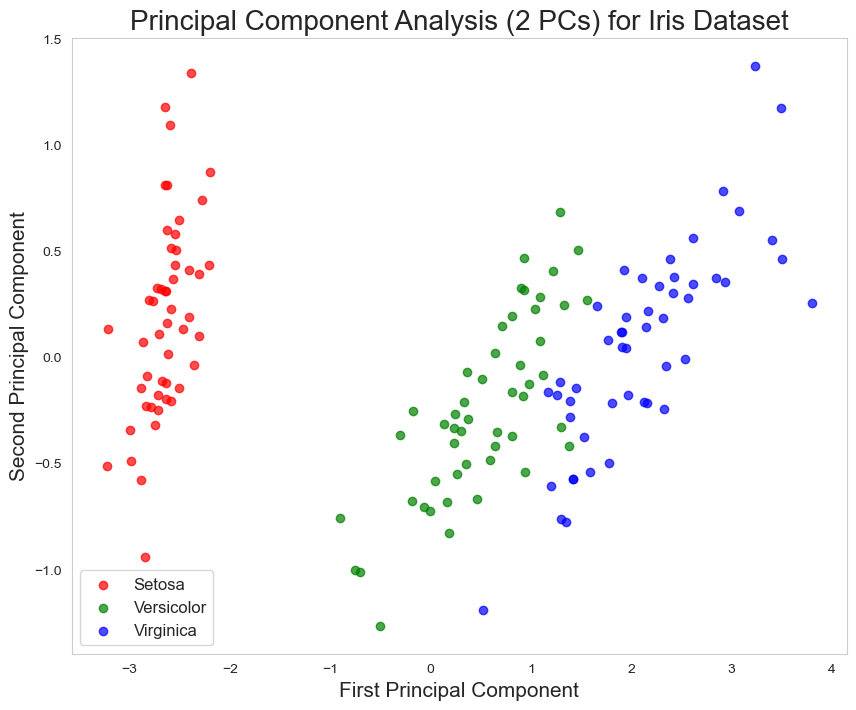

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(iris_df.iloc[:, :-1])
pca_df = pd.DataFrame(data=principal_components, columns=['PC 1', 'PC 2'])
pca_df['target'] = iris_df['target']

# Separate the data by iris type
setosa = pca_df[pca_df['target'] == 0]
versicolor = pca_df[pca_df['target'] == 1]
virginica = pca_df[pca_df['target'] == 2]

# Set the style
sns.set_style("whitegrid")

# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Scatter plot of setosa (red)
ax.scatter(setosa["PC 1"], setosa["PC 2"], c='r', label='Setosa', alpha=0.7)

# Scatter plot of versicolor (green)
ax.scatter(versicolor["PC 1"], versicolor["PC 2"], c='g', label='Versicolor', alpha=0.7)

# Scatter plot of virginica (blue)
ax.scatter(virginica["PC 1"], virginica["PC 2"], c='b', label='Virginica', alpha=0.7)

# Customize labels
ax.set_xlabel('First Principal Component', fontsize=15)
ax.set_ylabel('Second Principal Component', fontsize=15)
ax.set_title('Principal Component Analysis (2 PCs) for Iris Dataset', fontsize=20)

# Add legend
ax.legend(fontsize="large")

# Show plot
plt.show()


### Explained Variance

You can see above that the three classes in the dataset are fairly well separable, even though the data has been projected into two dimensions (down from 4 dimensions). As such, this compressed representation of the data is probably sufficient for the classification task at hand.

Let's confirm this evaluation by extracting the explained variance ratio from the fitted `pca` object. It has an attribute `explained_variance_ratio_` that describes the amount of variance explained by each principal component. (Remember you can find the full PCA documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).)

In the cell below, extract that information from `pca`:

In [26]:

# Extract the explained variance ratio from the pca object
evr_all_components = pca.explained_variance_ratio_

# Assign the explained variance ratios to variables
pc1_evr = evr_all_components[0]
pc2_evr = evr_all_components[1]

# Print the explained variance ratios
print(f"The first principal component explains {round(pc1_evr * 100, 3)}% of the variance")
print(f"The second principal component explains {round(pc2_evr * 100, 3)}% of the variance")
print()
print(f"Overall, the first two principal components explain {round(sum(evr_all_components[:2]) * 100, 3)}% of the variance")

The first principal component explains 92.462% of the variance
The second principal component explains 5.307% of the variance

Overall, the first two principal components explain 97.769% of the variance


As you can see, these first two principal components account for the vast majority of the overall variance in the dataset. This is indicative of the total information encapsulated in the compressed representation (2 dimensions) compared to the original encoding (4 dimensions).

## 5. Evaluate Model Performance with PCA

Since the first two principal components explain 95% of the variance in the data, we are hoping that the model performance will be similar on the lower-dimensional data, while improving computational speed.

In the cell below, we instantiate a new logistic regression model:

In [27]:

pca_model = LogisticRegression(random_state=42)
pca_model

LogisticRegression(random_state=42)

Now, fit the model on `X_train_pca` instead of `X_train`, and evaluate it on `X_test_pca` instead of `X_test`.

In [29]:

# Measure the time taken to fit and score the model
start = time.time()

# Fit the model on the PCA-transformed training data
pca_model.fit(X_train_pca, y_train)

# Score the model on the PCA-transformed test data
pca_model_score = pca_model.score(X_test_pca, y_test)

end = time.time()
pca_time_taken = end - start

print("Model score with PCA:", pca_model_score)

# Baseline model without PCA for comparison
# Split the original data into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(iris_df.iloc[:, :-1], iris_df['target'], test_size=0.2, random_state=42)

# Instantiate the logistic regression model for the baseline
baseline_model = LogisticRegression(random_state=42)

# Measure the time taken to fit and score the baseline model
start = time.time()

# Fit the baseline model on the training data
baseline_model.fit(X_train_orig, y_train_orig)

# Score the baseline model on the test data
baseline_model_score = baseline_model.score(X_test_orig, y_test_orig)

end = time.time()
baseline_time_taken = end - start

print("Baseline model score:", baseline_model_score)
print()
print("Time taken with PCA:", pca_time_taken)
print("Baseline time taken:", baseline_time_taken)

Model score with PCA: 0.9
Baseline model score: 1.0

Time taken with PCA: 0.024138212203979492
Baseline time taken: 0.034815311431884766


Although some accuracy is lost in this representation of the data, we were able to use half of the number of features to train the model! On average, this results in faster model fitting and predicting speeds.

(Comparing execution time is inexact since it is based on the CPU load as well as all of the current processes running on your computer at the time, but generally you should see a lower time taken with PCA than the baseline. Try re-running the model fitting cells a couple times if you aren't seeing this.)

This use case is a bit contrived (reducing 4 dimensions to 2 dimensions), but you can imagine how this might work if you reduced hundreds of dimensions down this way. We also are not seeing evidence of overfitting right now, but this could also help with overfitting on another dataset.

### Visualizing the Decision Boundaries

One other useful aspect of applying PCA to reduce data to two dimensions is that it allows us to visualize our model's decision boundaries in two dimensions. Run the cell below to visualize how our model uses the two principal components:

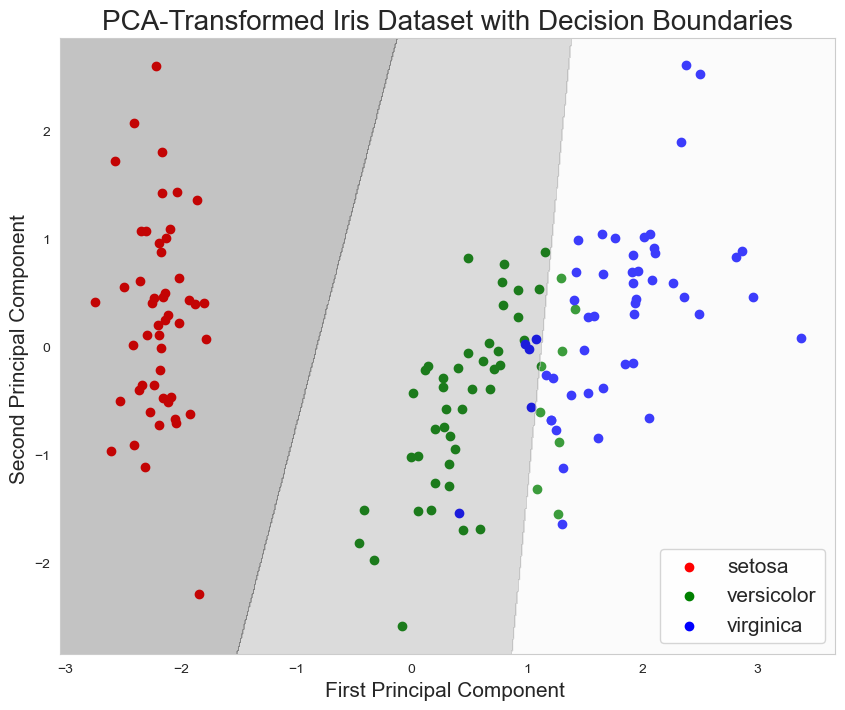

In [30]:
import numpy as np

# Combine all data into one df
X_all_pca = pd.concat([pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca)], axis=0)
X_all_pca.columns = ["PC 1", "PC 2"]
X_all_pca["target"] = pd.concat([y_train, y_test], axis=0).values

# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Scatter plot of all data points
colors = ["r", "g", "b"] # Setting up colors again in case they were edited earlier
for target_index in [0, 1, 2]:
    subset_rows = X_all_pca[X_all_pca["target"] == target_index]
    ax.scatter(subset_rows["PC 1"], subset_rows["PC 2"], c=colors[target_index])

# Get bounds and set step size for mesh grid
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
h = 0.01

# Build mesh grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot filled contour
ax.contourf(xx, yy, Z, alpha=0.25, cmap="gray")

# Customize labels
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('PCA-Transformed Iris Dataset with Decision Boundaries', fontsize = 20)
ax.legend(iris.target_names, fontsize=15);

## BONUS: Manifold Dimensionality Reduction

As mentioned previously, PCA is not the only technique for dimensionality reduction, although it is the only dimensionality reduction technique described in depth in our curriculum.

Another major form of dimensionality reduction is *manifold learning*, which you can read about more in depth [here](https://scikit-learn.org/stable/modules/manifold.html).

Here we'll have a quick demo of one type of manifold learning, isomap embedding ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)). Similar to PCA, isomap embedding creates components that can be plotted in 2D space.

In [31]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=2)

iso.fit(X_train)

X_train_iso = iso.transform(X_train)
X_test_iso = iso.transform(X_test)

iso_model = LogisticRegression()

start = time.time()

iso_model.fit(X_train_iso, y_train)
iso_model_score = iso_model.score(X_test_iso, y_test)

end = time.time()
iso_time_taken = end - start

print("Model score with iso:", iso_model_score)
print("Model score with PCA:", pca_model_score)
print("Baseline model score:", baseline_model_score)
print()
print("Time taken with iso:", iso_time_taken)
print("Time taken with PCA:", pca_time_taken)
print("Baseline time taken:", baseline_time_taken)

Model score with iso: 0.9333333333333333
Model score with PCA: 0.9
Baseline model score: 1.0

Time taken with iso: 0.008003711700439453
Time taken with PCA: 0.024138212203979492
Baseline time taken: 0.034815311431884766


As you can see, preprocessing with isomap embedding gets us slightly better performance than preprocessing with PCA with this particular dataset + model, while still being faster than the baseline.

This plot shows the components from the isomap embedding as well as the new decision boundaries:

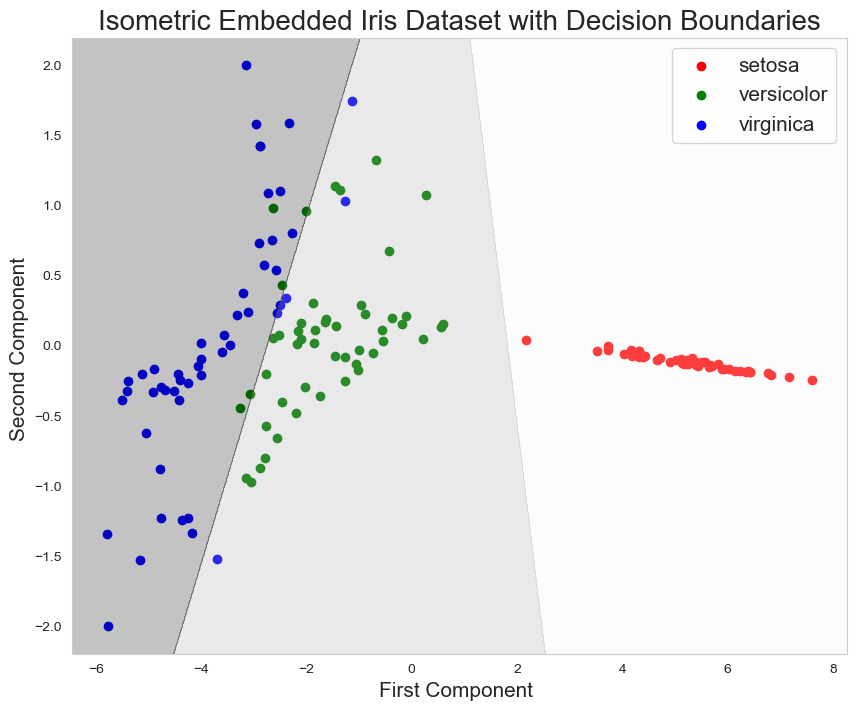

In [32]:
# Combine all data into one df
X_all_iso = pd.concat([pd.DataFrame(X_train_iso), pd.DataFrame(X_test_iso)], axis=0)
X_all_iso.columns = ["Component 1", "Component 2"]
X_all_iso["target"] = pd.concat([y_train, y_test], axis=0).values

# Set up figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()

# Scatter plot of all data points
colors = ["r", "g", "b"] # Setting up colors again in case they were edited earlier
for target_index in [0, 1, 2]:
    subset_rows = X_all_iso[X_all_iso["target"] == target_index]
    ax.scatter(subset_rows["Component 1"], subset_rows["Component 2"], c=colors[target_index])

# Get bounds and set step size for mesh grid
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
h = 0.01

# Build mesh grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = iso_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot filled contour
ax.contourf(xx, yy, Z, alpha=0.25, cmap="Greys")

# Customize labels
ax.set_xlabel('First Component ', fontsize = 15)
ax.set_ylabel('Second Component ', fontsize = 15)
ax.set_title('Isometric Embedded Iris Dataset with Decision Boundaries', fontsize = 20)
ax.legend(iris.target_names, fontsize=15);

## Summary 

In this lab, you applied PCA to the popular Iris Dataset in the context of a machine learning workflow. You looked at the performance of a simple classifier and the impact of PCA on the accuracy of the model and the time it took to run the model. You also used both PCA and isometric embedding to view higher-dimensional data in two dimensions, as well as the associated classifier decision boundaries.